In [1]:
!pip install wfdb

In [2]:
import wfdb

# Demo - Read a wfdb record using the 'rdrecord' function into a wfdb.Record object.
# Plot the signals, and show the data.
record = wfdb.rdrecord('I01') 
wfdb.plot_wfdb(record=record, title='Record') 
display(record.__dict__)

<Figure size 640x480 with 12 Axes>

{'adc_gain': [306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0,
  306.0],
 'adc_res': [16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
 'adc_zero': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'base_counter': None,
 'base_date': None,
 'base_time': None,
 'baseline': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'block_size': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'byte_offset': [None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None],
 'checksum': [-11409,
  21378,
  24619,
  302,
  2125,
  2450,
  -4606,
  30327,
  -27569,
  -13507,
  -4741,
  -28645],
 'comments': ['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension',
  'patient 1',
  'PVCs, noise'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat',
  'I01.dat'

In [3]:
# Demo - Read just a header
header = wfdb.rdheader('I01')
# display(header.__dict__)
signames = header.__dict__['sig_name']

[(idx, signame) for idx, signame in enumerate(signames)]

[(0, 'I'),
 (1, 'II'),
 (2, 'III'),
 (3, 'AVR'),
 (4, 'AVL'),
 (5, 'AVF'),
 (6, 'V1'),
 (7, 'V2'),
 (8, 'V3'),
 (9, 'V4'),
 (10, 'V5'),
 (11, 'V6')]

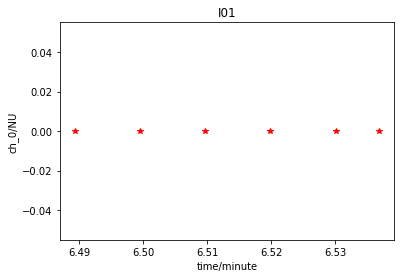

In [4]:
# Demo - Read part of a WFDB annotation file into a wfdb.Annotation object, and plot the samples
annotation = wfdb.rdann('I01', 'atr', sampfrom=100000, sampto=101000)
annotation.fs = 257
wfdb.plot_wfdb(annotation=annotation, time_units='minutes')

In [5]:
signals, fields = wfdb.rdsamp('I01', channels=[0, 1, 2, 3], sampfrom=100, sampto=15000)
display(signals)
display(fields)

array([[ 3.71895425,  1.41176471, -0.31045752, -2.69934641],
       [ 3.67647059,  1.42810458, -0.25163399, -2.68627451],
       [ 3.67973856,  1.41503268, -0.26797386, -2.68300654],
       ...,
       [ 2.91830065,  0.5620915 , -0.35947712, -1.87581699],
       [ 2.90196078,  0.53267974, -0.37254902, -1.85294118],
       [ 2.89215686,  0.51960784, -0.37581699, -1.83986928]])

{'base_date': None,
 'base_time': None,
 'comments': ['<age>: 65 <sex>: F <diagnoses> Coronary artery disease, arterial hypertension',
  'patient 1',
  'PVCs, noise'],
 'fs': 257,
 'n_sig': 4,
 'sig_len': 14900,
 'sig_name': ['I', 'II', 'III', 'AVR'],
 'units': ['mV', 'mV', 'mV', 'mV']}

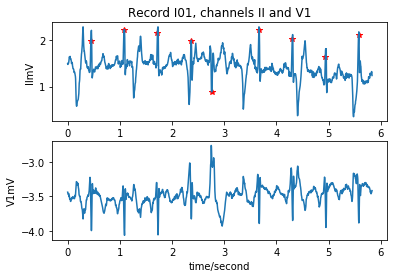

In [7]:
# Demo 5 - Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord('I01', channels=[1, 6], sampto = 1500)
annotation = wfdb.rdann('I01', 'atr', sampto = 1500)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record I01, channels II and V1',
               time_units='seconds')

annotation

In [8]:
record = wfdb.rdrecord('I01', channels=[1, 6])
annotation = wfdb.rdann('I01', 'atr')

signals = record.__dict__['p_signal']
channel_ii = signals[:, 0]
channel_v1 = signals[:, 1]

ticks = annotation.__dict__['sample']
symbols = annotation.__dict__['symbol']

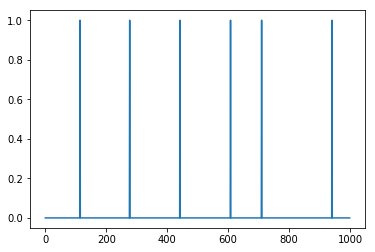

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

ticks_signal = np.zeros(channel_ii.shape)
ticks_signal[ticks] = 1.0
plt.plot(ticks_signal[:1000])

In [10]:
def parabola(a,n,r):
    assert n>2*r
    y = np.zeros(n, dtype = np.float32)
    x = np.array(range(2, 2 * r+1))
    for i in a:
        if i > r-1 and i <= n-r:
            # y[i-r-1:i+r+1] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
            y[i-r+1:i+r] = ((r+1)**2-(x-r-1)**2)/(r+1)**2
        elif i < r:
            y[:i+r] = ((r+1)**2-(x[r-i-1:]-r-1)**2)/(r+1)**2
        elif i<n:
            y[i-r+1:] = ((r+1)**2-(x[:r-1+(n-i)]-r-1)**2)/(r+1)**2
    return y


In [11]:
# parameters
window_size = 250
p_param = 10

# prepare channel_II and spikes
chii = channel_ii.reshape((1, -1))

p = parabola(ticks, len(ticks_signal), p_param)
targets = p.reshape((1, -1))

# join signal and spikes together in one array (2, ...)
chii_data = np.asarray([channel_ii, p], np.float32)

def selectFromSignal(signal, seqL, ninputs, numChan=2):
    """ 
    seqL:  number of timesteps to be used in recurrent nn
    ninput : is number of inputs in each timestep
    """
    segmentL  = seqL * ninputs; print(segmentL)
    inpOutSegment = tf.random_crop(signal, [numChan, segmentL])
    inputs = inpOutSegment[0, :]
    target = inpOutSegment[1, :]
    return inputs, target

N = chii_data.shape[1]
seqL = 20
fs = 257
ninputs = int(0.05*fs) 
batchSize = 8

testDataSize = 62600
val_perc = 0.15

# train test split
trainData = chii_data[:, :N-testDataSize]
testData = chii_data[:, N-testDataSize:]

# train validation split
valData = trainData[:, :int(trainData.shape[1]*val_perc)]
trainData = trainData[:, int(trainData.shape[1]*val_perc):]

print(trainData.shape, valData.shape, testData.shape)

# training data
trainData = tf.data.Dataset.from_tensors(trainData)
trainData = trainData.map(lambda x:  selectFromSignal(x, seqL, ninputs))
trainData = trainData.repeat()  # Repeat the input indefinitely.
trainData = trainData.batch(batchSize)

# validation data
valData = tf.data.Dataset.from_tensors(valData)
valData = valData.map(lambda x:  selectFromSignal(x, seqL, ninputs))
valData = valData.repeat()  # Repeat the input indefinitely.
valData = valData.batch(batchSize)

# test data
testData = tf.data.Dataset.from_tensors(testData)
testData = testData.map(lambda x:  selectFromSignal(x, seqL, ninputs))
testData = testData.repeat()  # Repeat the input indefinitely.
testData = testData.batch(batchSize)


(2, 340000) (2, 60000) (2, 62600)
240
240
240


In [ ]:
tf.__version

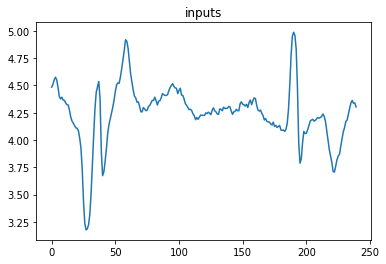

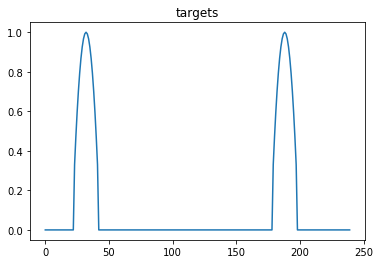

In [12]:
# let's visualize the model's input data and target data
iterator = trainData.make_initializable_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    sess.run(iterator.initializer)
    inp, targ = sess.run(next_element)
    
plt.plot(inp[0,:])
plt.title('inputs')
plt.show()
plt.plot(targ[0,:])
plt.title('targets')
plt.show()

In [13]:
from tensorflow.python.keras import layers

ffwdModel = tf.keras.Sequential()
ffwdModel.add(layers.Dense(64, activation='relu', input_shape=(seqL*ninputs,)))
ffwdModel.add(layers.Dense(64, activation='relu'))
ffwdModel.add(layers.Dense(seqL * ninputs))
ffwdModel.summary()

ffwdModel.compile(optimizer=tf.train.RMSPropOptimizer(0.001), loss='MSE',metrics=['mae'])
ffwdModel.fit(trainData, epochs=10, steps_per_epoch=1000, validation_data=valData, validation_steps=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                15424     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 240)               15600     
Total params: 35,184
Trainable params: 35,184
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
keep_dims is deprecated, use keepdims instead


TypeError: Error when checking model input: data should be a Numpy array, or list/dict of Numpy arrays. Found: <BatchDataset shapes: ((?, 240), (?, 240)), types: (tf.float32, tf.float32)>...